In [32]:
import os
import tensorflow as tf

class FontDataset(tf.data.Dataset):
    def __new__(cls, lhasa_dir, comp_dir):
        lhasa_images = sorted(os.listdir(lhasa_dir))
        comp_images = sorted(os.listdir(comp_dir))
        assert lhasa_images == comp_images, "Filenames in both directories must match"

        lhasa_paths = [os.path.join(lhasa_dir, img) for img in lhasa_images]
        comp_paths = [os.path.join(comp_dir, img) for img in comp_images]

        return tf.data.Dataset.from_tensor_slices((comp_paths, lhasa_paths))

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    return image

# Define the preprocessing function to ensure correct shapes
def preprocess_image(comp_path, lhasa_path):
    comp_image = load_image(comp_path)
    lhasa_image = load_image(lhasa_path)
    
    comp_image = tf.reshape(comp_image, [64, 1024, 1])
    lhasa_image = tf.reshape(lhasa_image, [64, 1024, 1])
    
    return comp_image, lhasa_image

# Create dataset
lhasa_dir = '/LG'
comp_dir = '/Comp'
dataset = FontDataset(lhasa_dir, comp_dir)
dataset = dataset.map(preprocess_image).batch(1)



In [34]:
import tensorflow as tf
from tensorflow.keras import layers

class ResizeLayer(layers.Layer):
    def __init__(self, target_height, target_width):
        super(ResizeLayer, self).__init__()
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        return tf.image.resize(inputs, [self.target_height, self.target_width])

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same', 
                      kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                               kernel_initializer=initializer, use_bias=False))
    
    result.add(layers.BatchNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())

    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[64, 1024, 1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 32, 512, 64)
        downsample(128, 4),  # (bs, 16, 256, 128)
        downsample(256, 4),  # (bs, 8, 128, 256)
        downsample(512, 4),  # (bs, 4, 64, 512)
        downsample(512, 4),  # (bs, 2, 32, 512)
        downsample(512, 4),  # (bs, 1, 16, 512)
        downsample(512, 4),  # (bs, 1, 8, 512)
        downsample(512, 4),  # (bs, 1, 4, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 8, 512)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 16, 512)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 32, 512)
        upsample(512, 4),  # (bs, 16, 64, 512)
        upsample(256, 4),  # (bs, 32, 128, 256)
        upsample(128, 4),  # (bs, 64, 256, 128)
        upsample(64, 4),  # (bs, 128, 512, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(1, 4, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=initializer, 
                                  activation='tanh')  # (bs, 64, 1024, 1)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
            x = ResizeLayer(skip.shape[1], skip.shape[2])(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
generator.summary()


Model: "functional_156"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_142     │ (None, 64, 1024,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_162      │ (None, 32, 512,   │      1,024 │ input_layer_142[… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_163      │ (None, 16, 256,   │    131,584 │ sequential_162[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_164      │ (None, 8, 128,    │    525,312 │ sequential_163[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_165      │ (None, 4, 64,     │  2,099,200 │ sequential_164[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_166      │ (None, 2, 32,     │  4,196,352 │ sequential_165[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_167      │ (None, 1, 16,     │  4,196,352 │ sequential_166[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_168      │ (None, 1, 8, 512) │  4,196,352 │ sequential_167[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_169      │ (None, 1, 4, 512) │  4,196,352 │ sequential_168[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_170      │ (None, 2, 8, 512) │  4,196,352 │ sequential_169[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_layer_10     │ (None, 1, 8, 512) │          0 │ sequential_170[0… │
│ (ResizeLayer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_42      │ (None, 1, 8,      │          0 │ resize_layer_10[… │
│ (Concatenate)       │ 1024)             │            │ sequential_168[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_171      │ (None, 2, 16,     │  8,390,656 │ concatenate_42[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_layer_11     │ (None, 1, 16,     │          0 │ sequential_171[0… │
│ (ResizeLayer)       │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_43      │ (None, 1, 16,     │          0 │ resize_layer_11[… │
│ (Concatenate)       │ 1024)             │            │ sequential_167[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_172      │ (None, 2, 32,     │  8,390,656 │ concatenate_43[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_44      │ (None, 2, 32,     │          0 │ sequential_172[0

 Total params: 54,419,713 (207.59 MB)

 Trainable params: 54,408,833 (207.55 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [35]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[64, 1024, 1], name='input_image')
    tar = layers.Input(shape=[64, 1024, 1], name='target_image')

    x = layers.concatenate([inp, tar])  # (bs, 64, 1024, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 32, 512, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 16, 256, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 8, 128, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 10, 130, 256)
    conv = layers.Conv2D(512, 4, strides=1, 
                         kernel_initializer=initializer, 
                         use_bias=False)(zero_pad1)  # (bs, 7, 127, 512)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 9, 129, 512)

    last = layers.Conv2D(1, 4, strides=1, 
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 6, 126, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
discriminator.summary()


Model: "functional_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 64, 1024,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 64, 1024,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 64, 1024,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 2)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_177      │ (None, 32, 512,   │      2,048 │ concatenate_49[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_178      │ (None, 16, 256,   │    131,584 │ sequential_177[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_179      │ (None, 8, 128,    │    525,312 │ sequential_178[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 10, 130,   │          0 │ sequential_179[0… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 7, 127,    │  2,097,152 │ zero_padding2d_8… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 127,    │      2,048 │ conv2d_111[0][0]  │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_107     │ (None, 7, 127,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 9, 129,    │          0 │ leaky_re_lu_107[… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 6, 126, 1) │      8,193 │ zero_padding2d_9… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,766,337 (10.55 MB)

 Trainable params: 2,764,545 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [36]:
import tensorflow as tf

class GANModel(tf.keras.Model):
    def __init__(self, generator, discriminator, lambda_l1=100):
        super(GANModel, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_l1 = lambda_l1
        self.gen_loss_metric = tf.keras.metrics.Mean(name="gen_loss")
        self.disc_loss_metric = tf.keras.metrics.Mean(name="disc_loss")

    def compile(self, gen_optimizer, disc_optimizer, gen_loss_fn, disc_loss_fn):
        super(GANModel, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn

    def train_step(self, data):
        input_image, target = data

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator(input_image, training=True)

            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)

            gen_total_loss = self.gen_loss_fn(disc_generated_output, gen_output, target)
            disc_loss = self.disc_loss_fn(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

        self.gen_loss_metric.update_state(gen_total_loss)
        self.disc_loss_metric.update_state(disc_loss)

        return {"gen_loss": self.gen_loss_metric.result(), "disc_loss": self.disc_loss_metric.result()}

    def reset_metrics(self):
        self.gen_loss_metric.reset_state()
        self.disc_loss_metric.reset_state()


In [37]:
# Loss functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

LAMBDA = 100

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [38]:
# Define and compile the models
generator = Generator()
discriminator = Discriminator()

# Instantiate the custom GAN model
gan_model = GANModel(generator, discriminator, lambda_l1=LAMBDA)

# Compile the custom GAN model
gan_model.compile(gen_optimizer=generator_optimizer,
                  disc_optimizer=discriminator_optimizer,
                  gen_loss_fn=generator_loss,
                  disc_loss_fn=discriminator_loss)


In [41]:
# Train the model using .fit method
gan_model.fit(dataset, epochs=200)

Epoch 1/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - disc_loss: 0.1080 - gen_loss: 28.8573
Epoch 2/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - disc_loss: 0.1168 - gen_loss: 28.2123
Epoch 3/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - disc_loss: 0.0812 - gen_loss: 28.7838
Epoch 4/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - disc_loss: 0.0943 - gen_loss: 28.5907
Epoch 5/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - disc_loss: 0.0843 - gen_loss: 29.0613
Epoch 6/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - disc_loss: 0.1344 - gen_loss: 28.6474
Epoch 7/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - disc_loss: 0.1093 - gen_loss: 28.9482
Epoch 8/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - disc_loss: 0.1077 - gen_loss: 28.7089
Epoch 9/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - disc_loss: 0.1097 - gen_loss: 29.3121
Epoch 10/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - disc_loss: 0.0918 - gen_loss: 29.2141
Epoch 11/200
1000/1000 ━━━━━━

KeyboardInterrupt: 

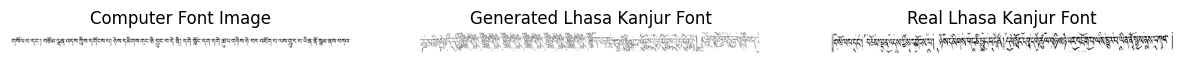

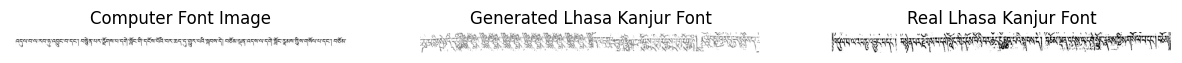

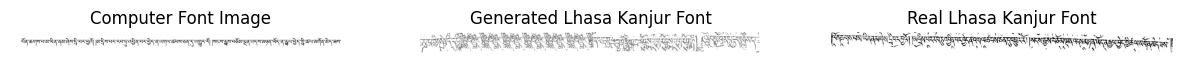

2024-06-28 05:56:01.858887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
import matplotlib.pyplot as plt

# Function to display images
def display_generated_images(generator, dataset, num_images=3):
    for comp_image, target_image in dataset.take(num_images):
        generated_image = generator(comp_image, training=False)
        
        plt.figure(figsize=(15, 5))

        # Display computer font image
        plt.subplot(1, 3, 1)
        plt.title("Computer Font Image")
        plt.imshow(comp_image[0, :, :, 0], cmap='gray')
        plt.axis('off')
        
        # Display generated Lhasa Kanjur font image
        plt.subplot(1, 3, 2)
        plt.title("Generated Lhasa Kanjur Font")
        plt.imshow(generated_image[0, :, :, 0], cmap='gray')
        plt.axis('off')
        
        # Display real Lhasa Kanjur font image
        plt.subplot(1, 3, 3)
        plt.title("Real Lhasa Kanjur Font")
        plt.imshow(target_image[0, :, :, 0], cmap='gray')
        plt.axis('off')

        plt.show()

# Display generated images
display_generated_images(generator, dataset)


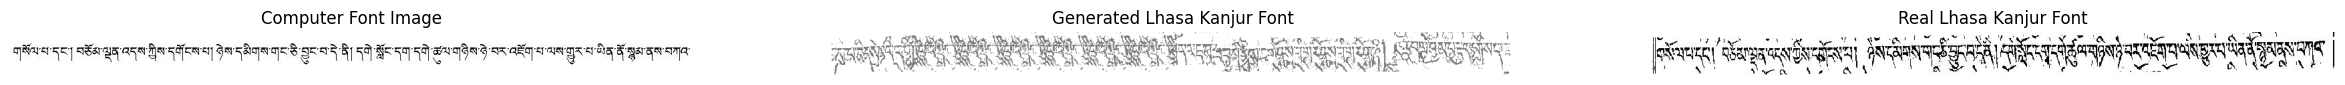

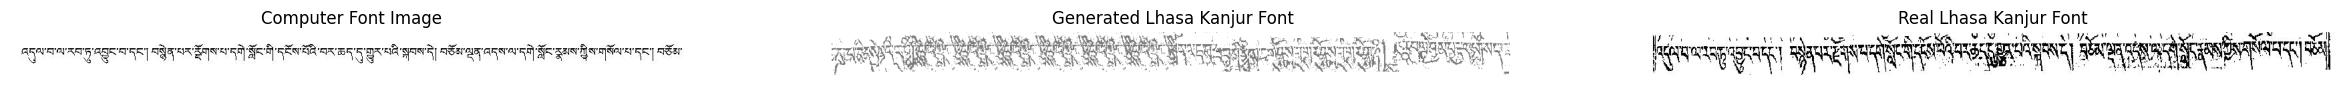

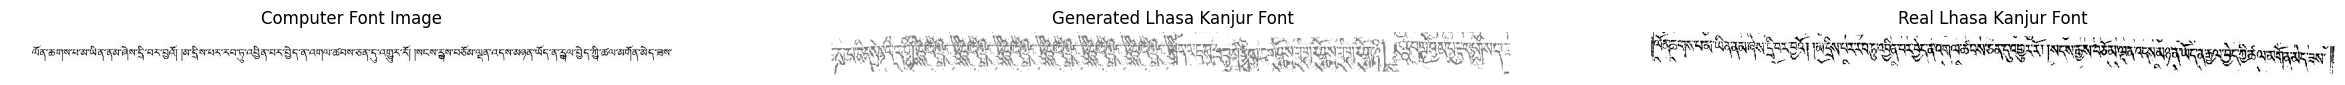

2024-06-28 06:01:32.859201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
import matplotlib.pyplot as plt

# Function to display images with a larger scale
def display_generated_images(generator, dataset, num_images=3, scale=10):
    for comp_image, target_image in dataset.take(num_images):
        generated_image = generator(comp_image, training=False)
        
        plt.figure(figsize=(3 * scale, scale))

        # Display computer font image
        plt.subplot(1, 3, 1)
        plt.title("Computer Font Image")
        plt.imshow(comp_image[0, :, :, 0], cmap='gray')
        plt.axis('off')
        
        # Display generated Lhasa Kanjur font image
        plt.subplot(1, 3, 2)
        plt.title("Generated Lhasa Kanjur Font")
        plt.imshow(generated_image[0, :, :, 0], cmap='gray')
        plt.axis('off')
        
        # Display real Lhasa Kanjur font image
        plt.subplot(1, 3, 3)
        plt.title("Real Lhasa Kanjur Font")
        plt.imshow(target_image[0, :, :, 0], cmap='gray')
        plt.axis('off')

        plt.show()

# Display generated images with a larger scale
display_generated_images(generator, dataset, num_images=3, scale=10)
